# Predicting Heart Disease Presence Using Clinical Attributes: Project Report
### Introduction

Cardiovascular diseases are among the leading causes of death worldwide. Early detection and prevention are crucial in reducing the morbidity and mortality associated with these diseases (World Health Organization, 2021). The [UCI Heart Disease dataset](https://archive.ics.uci.edu/dataset/45/heart+disease) provides various clinical attributes of patients that can be used to predict the presence of heart disease (Dua & Graff, 2019). The goal of this project is to develop a predictive model to determine whether a patient has heart disease based on their clinical attributes. By accurately predicting heart disease, healthcare providers can better identify at-risk individuals and take preventive measures.

**Predictive Question:** Can we use the Cleveland Clinic patients information available to us to predict whether new patients have a heart disease?

To answer that question, let's first describe the database. 

The dataset contains information on 3 patient groups derived from clinical and noninvasive test results:

- 303 patients undergoing angiography at the Cleveland Clinic in Cleveland.
- 194 patients undergoing angiography at the Hungarian Institute of Cardiology in Budapest, Hungary.
- 123 patients from the University Hospitals in Zurich and Basel, Switzerland.

The UCI Heart Disease dataset contains 14 attributes, including age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, ST depression induced by exercise, the slope of the peak exercise ST segment, number of major vessels colored by fluoroscopy, and a categorical variable representing the presence or absence of heart disease ('num'). The 'num' column is our target variable, indicating the presence of heart disease (1, 2, 3, 4) or absence (0).

### Methods & Results
#### Data Loading, Wrangling, and Cleaning 
As we have three processed datasets, I am going to use the Cleveland data as the main data to build my model on because it is what the authors of the paper suggest in the introductory paper for the dataset (Detrano et al., 1989). First, we load the necessary libraries and the Cleveland dataset from a URL on GitHub. Because the data does not have column names, we rename the columns for better readability. We then preprocess the data by mutating the 'num' column to create a classification target variable, where the presence of heart disease (1, 2, 3, 4) is encoded as "Yes" and the absence is encoded as "No". Additionally, we handle missing values by replacing "?" with NA and omitting these rows from the dataset to perform a comprehensive analysis.

In [165]:
library(tidyverse)
library(tidymodels)
library(readr)
library(dplyr)
library(ggplot2)
options(repr.matrix.max.rows = 6)

In [166]:
URL <- "https://raw.githubusercontent.com/Kassiyett/dsci-100-2024s1/main/data/heart_disease/processed.cleveland.data"
heart_data <- read_csv(URL,
                col_names = FALSE) |>
rename(age = X1,
       sex = X2,
       cp = X3,
       trestbps = X4,
       chol = X5,
       fbs = X6,
       restecg = X7,
       thalach = X8,
       exang = X9,
       oldpeak = X10,
      slope = X11,
       ca = X12,
       thal = X13,
       num = X14)
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [167]:
heart_data <- heart_data |>
mutate(num = ifelse(num == 0, "No", "Yes")) |>
mutate(num = as_factor(num))

In [168]:
heart_data[heart_data == "?"] <- NA
heart_data <- na.omit(heart_data)

heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,No
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,Yes
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,Yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,Yes


From the tables above, we can see that there are 6 rows with missing values, as after cleaning the data, we have 6 fewer rows. It was 303 before cleaning, and now it is 297. 

#### Exploratory Data Analysis
To answer our question, I am going to choose the predictors that I will use in my classification. For this purpose, I analyzed the correlation of different features and identified the most significant ones: age, maximum heart rate achieved, and ST depression induced by exercise. Therefore, I am first going to select these columns to wrangle the data.

Then, we will summarize the number of observations in each class and their respective percentages within the data to get an overview.

In [169]:
heart_data <- heart_data |>
select(age, thalach, oldpeak, cp, num)

heart_data

age,thalach,oldpeak,cp,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,150,2.3,1,No
67,108,1.5,4,Yes
67,129,2.6,4,Yes
⋮,⋮,⋮,⋮,⋮
68,141,3.4,4,Yes
57,115,1.2,4,Yes
57,174,0.0,2,Yes


In [170]:
num_obs <- nrow(heart_data)
heart_data |>
  group_by(num) |>
  summarize(
    age = mean(age),
      thalach = mean(thalach),
      oldpeak = mean(oldpeak),
      cp = mean(cp),
    percentage = n() / num_obs * 100)

num,age,thalach,oldpeak,cp,percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,52.64375,158.5813,0.598750,2.793750,53.87205
Yes,56.75912,139.1095,1.589051,3.583942,46.12795


The table above presents the mean values of key clinical attributes for patients with and without heart disease, along with the percentage distribution of each group within the dataset.

#### Data Visualization

In order to answer our question, we need to justify the use of predictors, which I am going to do with the help of visualization. Below are the plots, which describe the relationship between different attributes and disease status.

##### Scatter Plot of Age vs. Maximum Heart Rate Achieved by Heart Disease Status

The scatter plot below shows that younger patients tend to achieve higher maximum heart rates, while older patients tend to have lower maximum heart rates. Patients with heart disease are more dispersed across the age range, with a noticeable concentration among older patients. Patients without heart disease tend to cluster more in the younger age groups with higher maximum heart rates. This indicates the relationship between Age, Maximum Heart Rate Achieved, and Heart Disease Status.

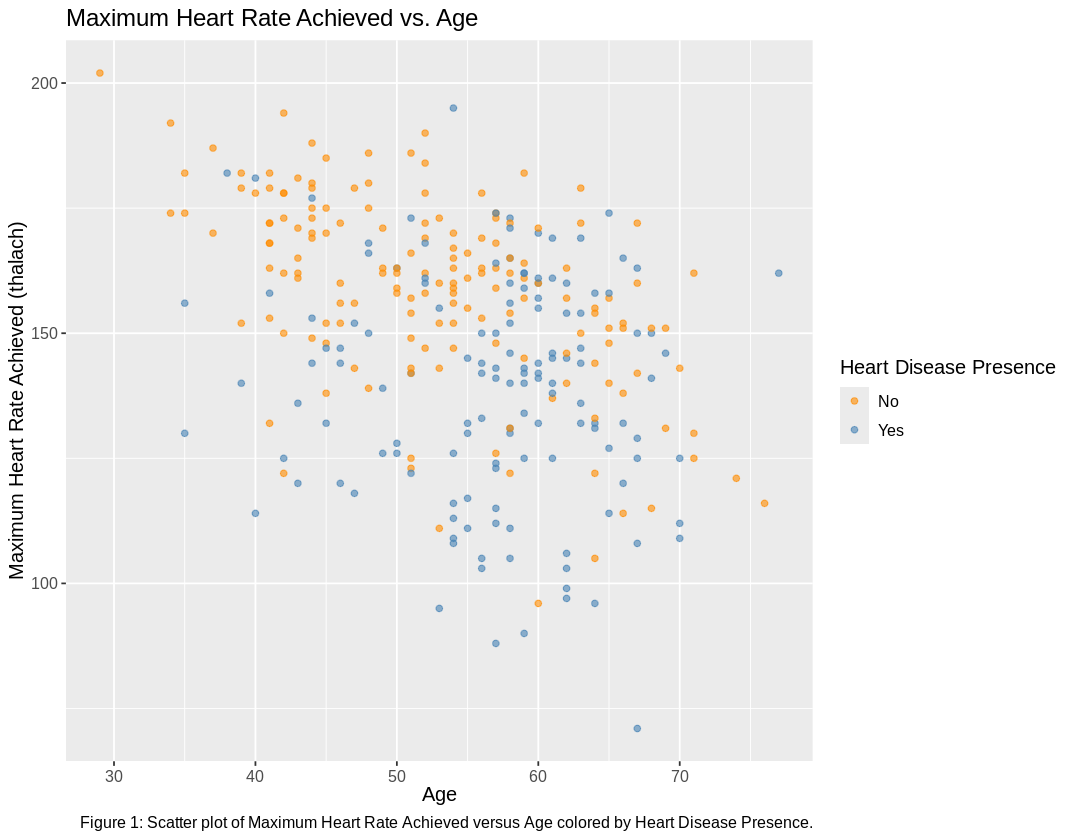

In [171]:
library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 7)

age_thalach_plot <- heart_data |>
  ggplot(aes(x = age, y = thalach, color = num)) +
  geom_point(alpha = 0.6) +
  labs(title = "Maximum Heart Rate Achieved vs. Age",
       x = "Age",
       y = "Maximum Heart Rate Achieved (thalach)",
       color = "Heart Disease Presence",
    caption = "Figure 1: Scatter plot of Maximum Heart Rate Achieved versus Age colored by Heart Disease Presence.") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

age_thalach_plot

##### Scatter Plot of Maximum Heart Rate Achieved vs. ST Depression Induced by Exercise (Oldpeak) by Heart Disease Status

In the plot below, there is a notable trend where patients with higher oldpeak values tend to have heart disease (blue points). Patients with heart disease are more dispersed across higher oldpeak values. Patients without heart disease tend to cluster around lower oldpeak values, often close to zero. Patients with higher oldpeak values (above 2) are more likely to have heart disease, regardless of the maximum heart rate achieved. Patients with lower oldpeak values (around 0) are less likely to have heart disease, especially if their maximum heart rate achieved is high. The overlap between the two groups indicates that oldpeak and thalach together can provide significant information for predicting heart disease presence.


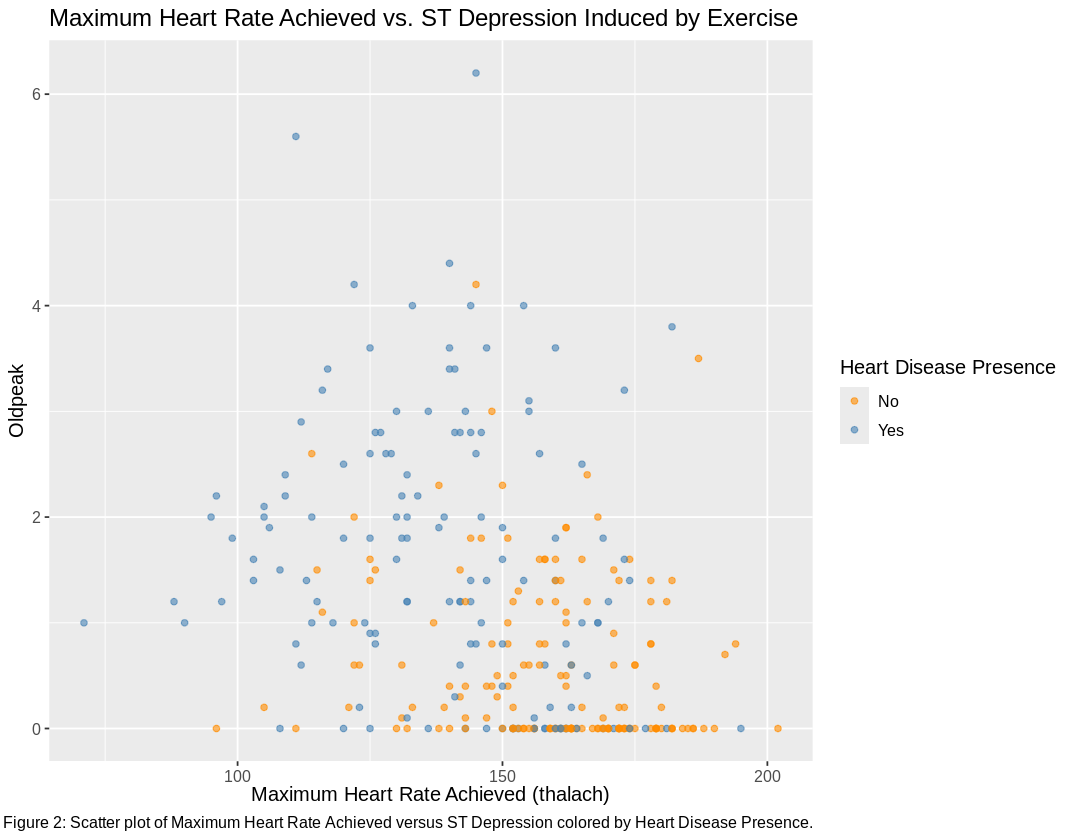

In [172]:
thalach_oldpeak_plot <- heart_data |>
  ggplot(aes(x = thalach, y = oldpeak, color = num)) +
  geom_point(alpha = 0.6) +
  labs(title = "Maximum Heart Rate Achieved vs. ST Depression Induced by Exercise",
       x = "Maximum Heart Rate Achieved (thalach)",
       y = "Oldpeak",
       color = "Heart Disease Presence",
      caption = "Figure 2: Scatter plot of Maximum Heart Rate Achieved versus ST Depression colored by Heart Disease Presence.") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

thalach_oldpeak_plot



I think that all of the variables above are significant and their distribution was discussed earlier. Additionally, there is a notable correlation between chest pain and heart disease presence, that can be helpful in prediction. This relationship is visualized and described below.

##### Bar Plot of Heart Disease Presence by Chest Pain

The plot shows that patients with asymptomatic chest pain (type 4) are more likely to have heart disease. Patients with typical angina (type 1) are less likely to have heart disease.

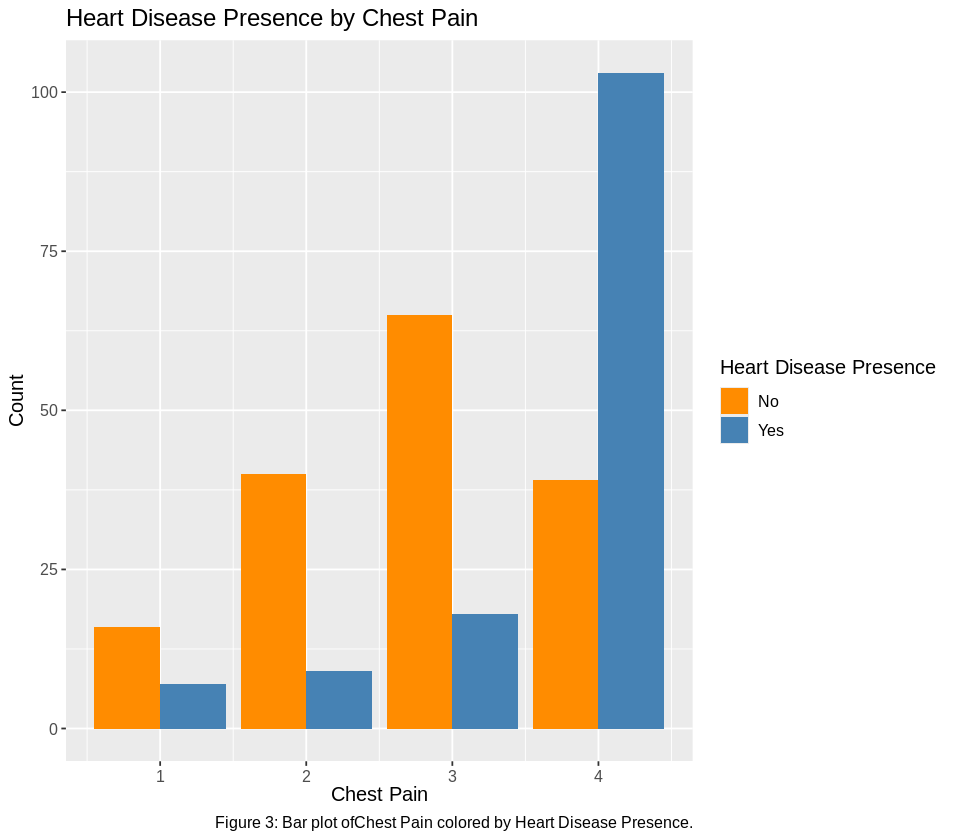

In [173]:
# Bar plot for the count of heart disease presence by sex
options(repr.plot.width = 8, repr.plot.height = 7)

ggplot(heart_data, aes(x = cp, fill = num)) +
  geom_bar(position = "dodge") +
  labs(x = "Chest Pain",
       y = "Count",
       fill = "Heart Disease Presence",
       title = "Heart Disease Presence by Chest Pain",
      caption = "Figure 3: Bar plot ofChest Pain colored by Heart Disease Presence.") +
  scale_fill_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))


### Methods & Results

The analysis will involve a classification approach, as the target variable 'num' is binary. The steps will include:

- Building a K-Nearest Neighbors (KNN) model with selected variables: age, maximum heart rate achieved, and ST depression induced by exercise. It is chosen for its simplicity and effectiveness in classification tasks.
- The model will be trained using k-fold cross-validation to ensure robustness and to prevent overfitting. Hyperparameter tuning will be performed to select the optimal number of neighbors (k).
- Evaluating and analyzing model performance.

#### Data analysis

To ensure our model is robust and generalizable, we split the dataset into training (75%) and testing (25%) sets randomly, stratified by the target variable ('num'). This helps maintain the same proportion of heart disease presence in both sets. Additionally, we set a seed parameter to ensure that this process is reproducible, allowing the same split to be obtained in future runs.

Below are the steps taken to build and evaluate the KNN model:
We created a preprocessing recipe to prepare the data for modeling, set the number of neighbors to 3, combined the preprocessing recipe and the KNN model specification into a workflow,fitted to the training data. Then we made predictions on the testing set using the fitted workflow. We then evaluated the model's performance using various metrics, including accuracy, precision, recall, and the confusion matrix. This are the descriptions of each metrics:
- Accuracy is the proportion of correctly predicted instances.
- Precision - the proportion of true positive predictions among all positive predictions.
- Recall - the proportion of true positive predictions among all actual positive instances.
- Confusion Matrix - a table that shows the counts of true positive, true negative, false positive, and false negative predictions.

In [174]:
set.seed(123)

data_split <- initial_split(heart_data, prop = 0.75, strata = num)
train_data <- training(data_split)
test_data <- testing(data_split)


# Create a recipe for preprocessing
heart_recipe <- recipe(num ~ ., data = train_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

# Specify the KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# Create a workflow, add the recipe and model, and fit the model
knn_fit <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = train_data)

# Make predictions on the testing set
heart_test_predictions <- predict(knn_fit, test_data) %>%
  bind_cols(test_data)

# Evaluate the model's performance
accuracy <- heart_test_predictions %>%
  metrics(truth = num, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

heart_test_predictions |> pull(num) |> levels()

precision <- heart_test_predictions %>%
  precision(truth = num, estimate = .pred_class, event_level = "second")

recall <- heart_test_predictions %>%
  recall(truth = num, estimate = .pred_class, event_level = "second")

confusion <- heart_test_predictions %>%
  conf_mat(truth = num, estimate = .pred_class)

# Print the metrics
# accuracy
# precision
# recall
# confusion

[1] "No"  "Yes"

In [175]:
# Printing 
accuracy <- accuracy %>%
  select(.estimate) %>%
  pull()

precision <- precision %>%
  select(.estimate) %>%
  pull()

recall <- recall %>%
  select(.estimate) %>%
  pull()

# Combine metrics into a table
metrics_table <- tibble(
  Metric = c("Accuracy", "Precision", "Recall"),
  Value = c(accuracy, precision, recall)
)

library(knitr)
kable(metrics_table, caption = "Table 1: Accuracy, Precision, and Recall of the Model")
# Print confusion matrix with a caption
cat("Table 2: Confusion Matrix of the Model\n")
print(confusion)



Table: Table 1: Accuracy, Precision, and Recall of the Model

|Metric    |     Value|
|:---------|---------:|
|Accuracy  | 0.7333333|
|Precision | 0.7142857|
|Recall    | 0.7142857|

Table 2: Confusion Matrix of the Model
          Truth
Prediction No Yes
       No  30  10
       Yes 10  25


The KNN model's initial accuracy was 73.33%, with precision and recall both at 71.43%. To further validate the robustness and generalizability of our KNN model, we performed 5-fold cross-validation. This method provides a more reliable assessment of the model's performance by ensuring it is tested on different subsets of the data multiple times. We ensure that our model is thoroughly validated, reducing the risk of overfitting and providing a more reliable estimate of its performance on unseen data.

In [176]:
set.seed(123)

# create the 25/75 split of the training data into training and validation
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_subtrain <- training(heart_split)
heart_validation <- testing(heart_split)

heart_recipe <- recipe(num ~ .,
                        data = heart_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_subtrain)

validation_predicted <- predict(knn_fit, heart_validation) |>
  bind_cols(heart_validation)

acc <- validation_predicted |>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc

[1] 0.7333333

The accuracy estimate using this split is 73.33%. Now we repeat the above code 4 more times, which generates 4 more splits.

In [177]:
heart_vfold <- vfold_cv(train_data, v = 5, strata = num)

heart_recipe <- recipe(num ~ .,
                        data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = heart_vfold)

knn_fit |>
  collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7159596,5,0.02801123,Preprocessor1_Model1
roc_auc,binary,0.7666270,5,0.03673860,Preprocessor1_Model1


Using 5-fold cross-validation, the mean accuracy was 71.59%, indicating consistent performance across different subsets of data. To optimize the performance of our KNN model, we performed hyperparameter tuning to find the best number of neighbors (k). This process involves testing various values of k and selecting the one that yields the highest accuracy. This process of hyperparameter tuning ensures that we select the optimal number of neighbors for our KNN model, improving its performance and reliability on the task of predicting heart disease presence.

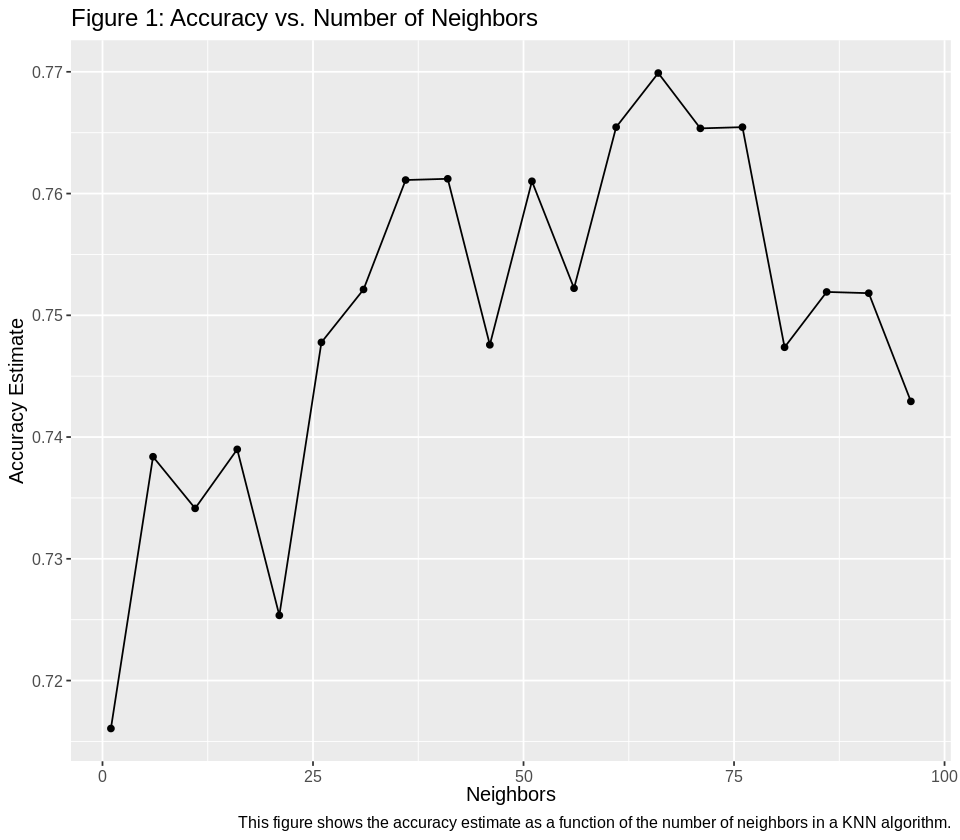

In [178]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
      title = "Figure 1: Accuracy vs. Number of Neighbors",
    caption = "This figure shows the accuracy estimate as a function of the number of neighbors in a KNN algorithm.") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [179]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 66

After identifying the optimal number of neighbors (k) through hyperparameter tuning, we proceeded to fit the final KNN model using this optimal k value. We then evaluated the model's performance on the test set to ensure its generalizability to new data.

In [180]:
heart_recipe <- recipe(num ~ ., data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = train_data)

heart_test_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

accuracy <- heart_test_predictions |>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

precision <- heart_test_predictions |>
    precision(truth = num, estimate = .pred_class, event_level="second")

recall <- heart_test_predictions |>
    recall(truth = num, estimate = .pred_class, event_level="second")


confusion <- heart_test_predictions |>
             conf_mat(truth = num, estimate = .pred_class)

In [181]:
# Printing 
accuracy <- accuracy %>%
  select(.estimate) %>%
  pull()

precision <- precision %>%
  select(.estimate) %>%
  pull()

recall <- recall %>%
  select(.estimate) %>%
  pull()

# Combine metrics into a table
metrics_table <- tibble(
  Metric = c("Accuracy", "Precision", "Recall"),
  Value = c(accuracy, precision, recall)
)

kable(metrics_table, caption = "Table 3: Accuracy, Precision, and Recall of the Model after Tuning")

# Print confusion matrix with a caption
cat("Table 2: Confusion Matrix of the Model after Tuning\n")
print(confusion)



Table: Table 3: Accuracy, Precision, and Recall of the Model after Tuning

|Metric    |     Value|
|:---------|---------:|
|Accuracy  | 0.7866667|
|Precision | 0.8800000|
|Recall    | 0.6285714|

Table 2: Confusion Matrix of the Model after Tuning
          Truth
Prediction No Yes
       No  37  13
       Yes  3  22


Hyperparameter tuning identified 66 as the optimal number of neighbors, yielding an accuracy of 78.67%, precision of 88%, and recall of 62% on the test set.

### Discussion
#### Discussion of results

Hyperparameter tuning and cross-validation improved the model's overall performance but highlighted the balance required between precision and recall. The confusion matrix showed that the model correctly predicted 37 out of 40 negative cases and 22 out of 35 positive cases. The accuracy improved from 73.33% to 79%, indicating that the model's overall correctness increased after tuning and cross-validation. Precision improved significantly from 71.43% to 84%, meaning the model became much better at correctly identifying patients with heart disease without misclassifying those without it. Recall decreased from 71.43% to 60%, indicating that the tuned model missed more actual cases of heart disease compared to the model before tuning. This trade-off suggests that while the model became more precise, it became less sensitive to identifying all true positive cases.

In medical diagnostics, high recall is often prioritized to minimize the risk of missing positive cases (false negatives). However, this must be balanced with precision to avoid unnecessary treatments. A recall of 60% may not be sufficient if the cost of missing a heart disease diagnosis is high. The relatively high precision (84%) is beneficial, but the low recall suggests that the model is not detecting a significant number of true heart disease cases.

#### Expected vs. Actual Findings

Our findings partially met expectations. We anticipated that attributes such as age and maximum heart rate achieved would be significant predictors, which was confirmed by our analysis. However, the drop in recall after tuning the model was unexpected. While precision improved significantly, indicating fewer false positives, the decrease in recall suggests that the model missed more actual heart disease cases than initially anticipated.

#### Impact of Findings

These findings have important implications for healthcare providers. The improved precision means that when the model predicts heart disease, it is more likely to be correct, reducing unnecessary treatments and anxiety for patients. However, the lower recall indicates that some patients with heart disease might be missed. An accurate and reliable model can aid in early detection and prevention, potentially reducing the morbidity and mortality associated with heart disease.

#### Future Questions and Directions
Future research could explore the following questions:

- Improving Recall: How can we improve the recall of the model without significantly compromising precision? This might involve exploring different algorithms or combining multiple models.
- Additional Predictors: Are there other clinical attributes or external factors (e.g., lifestyle, genetic predispositions) that could enhance the model's predictive power?
- Real-World Application: How does the model perform with real-world data from diverse populations beyond the Cleveland, Budapest, and Switzerland datasets? Testing and validating the model on a broader dataset could ensure its generalizability.
- Cost-Sensitive Learning: Can we implement cost-sensitive learning techniques to penalize false negatives more heavily, ensuring that cases of heart disease are less likely to be missed?

By addressing these questions, we can refine our predictive models and improve their utility in clinical settings, ultimately contributing to better patient outcomes and more effective healthcare interventions.

### References
Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J. J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American journal of cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9

World Health Organization. (2021). Cardiovascular diseases (CVDs). Retrieved from https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

Source of your data:
Dua, D., & Graff, C. (2019). UCI machine learning repository: Heart disease data set. Retrieved from https://archive.ics.uci.edu/dataset/45/heart+disease